In [10]:
# Import other libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
plt.rc('font', size=16)
import os
import sys
chemin_dev = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if chemin_dev not in sys.path:
    sys.path.append(chemin_dev)
from options_pricing.scripts import black_scholes as bs
from options_pricing.scripts import data_processing as dp


In [12]:
def build_model(input_shape, learning_rate=0.001):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.Dense(128, name='dense_1')(input_layer)
    x = tfkl.Activation('leaky_relu', name='relu_1')(x)
    x = tfkl.Dense(128, name='dense_2')(x)
    x = tfkl.Activation('leaky_relu', name='relu_2')(x)
    output = tfkl.Dense(1, name='output')(x)
    output_layer = tfkl.Activation('relu', name='output_activation')(output)
    # we use relu activation function to avoid negative prices

    model = tfk.Model(input_layer, output_layer, name='pricing_model')
    opt = tfk.optimizers.Adam(learning_rate=learning_rate)
    loss = tfk.losses.MeanSquaredError()
    mtr = ['mse']
    model.compile(optimizer=opt, loss=loss, metrics=mtr)
    return model

In [ ]:
import matplotlib.pyplot as plt

def plot_histories(history):
    import matplotlib.pyplot as plt

    # Récupérer les valeurs de MSE à partir de l'epoch 50
    mse_values_subset = mse_values[49:]

    # Créer une liste d'epochs à partir de l'epoch 50
    epochs_subset = list(range(50, 501))

    # Afficher le graphique de l'évolution de MSE à partir de l'epoch 50
    plt.plot(epochs_subset, mse_values_subset)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Evolution de MSE à partir de l\'epoch 50')
    plt.show()
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Utilisation de la fonction pour tracer les courbes
plot_histories(history)


In [11]:
df_options = pd.read_csv('../../data/options/options_processed.csv')
df_options_c = df_options.loc[df_options['call_put'] == 'Call']


In [19]:
params = {
    'test_size' : 0.1,
    'test_value' : 200, # if we choose no to train_test_split
    'n_rows' : 10000,
    'epochs': 1000,
    'batch_size': 32,
    'features': ['strike','vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'stock_price','time_to_maturity', 'interest_rate'],
    "callbacks": {
        "EarlyStopping": {
            "monitor": "val_mse",
            "patience": 20,
            'min_delta': 0.01,
            "restore_best_weights": True,
        },
        "ReduceLROnPlateau": {
            "monitor": "val_mse",
            "factor": 0.1,
            "patience": 10,
            "min_lr": 1e-5,
        },
    },
    
    "regularizer" : {
        "L2": {
            "l2": 0.0005,
        },
    }
}

In [20]:
X_train_val, X_test, y_train_val, y_test, scaler = dp.create_train_test_set_random(df_options_c, params['test_size'], params['n_rows'], params['features'])
X_test_unscal = scaler.inverse_transform(X_test)# for bs model
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=len(X_test))

In [21]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(8000, 10) (8000,)
(1000, 10) (1000,)
(1000, 10) (1000,)


In [22]:
callbacks = [
    getattr(tfk.callbacks, name)(**params) for name, params in params['callbacks'].items()
]
model_with_callbacks = build_model(X_train.shape[1:]) # nombre de features
model_with_callbacks.summary()

Model: "pricing_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (Activation)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_activation (Activation)  │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history_with_callbacks = model_with_callbacks.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=params['epochs'], 
    batch_size=params['batch_size'],
    callbacks=callbacks).history

Epoch 1/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 103.4679 - mse: 103.4679 - val_loss: 31.6535 - val_mse: 31.6535 - learning_rate: 0.0010
Epoch 2/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3386 - mse: 17.3386 - val_loss: 15.9232 - val_mse: 15.9232 - learning_rate: 0.0010
Epoch 3/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.8527 - mse: 14.8527 - val_loss: 12.3514 - val_mse: 12.3514 - learning_rate: 0.0010
Epoch 4/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.2223 - mse: 15.2223 - val_loss: 10.6011 - val_mse: 10.6011 - learning_rate: 0.0010
Epoch 5/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.7852 - mse: 10.7852 - val_loss: 9.1965 - val_mse: 9.1965 - learning_rate: 0.0010
Epoch 6/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 9.2114 - mse: 9.2114 - val_loss: 11.5730 - val_mse: 11.5730 - learning_rate: 0.0010
Epoch 7/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 15.9120 - mse: 15.9120 - val_loss: 7.0408 - val_

In [ ]:
y_pred = model_with_callbacks.predict(X_test)
mape, mae, mse, r2 = bs.compute_metrics(y_test, y_pred, params)
# for bs evaluation 
X_test_df, y_test_df = dp.from_np_to_df(X_test_unscal, y_test, params['features'])
df_price_bs, mape_bs, mae_bs, mse_bs, r2_bs = bs.evaluate_bs_options_pricing(y_test_df, X_test_df)

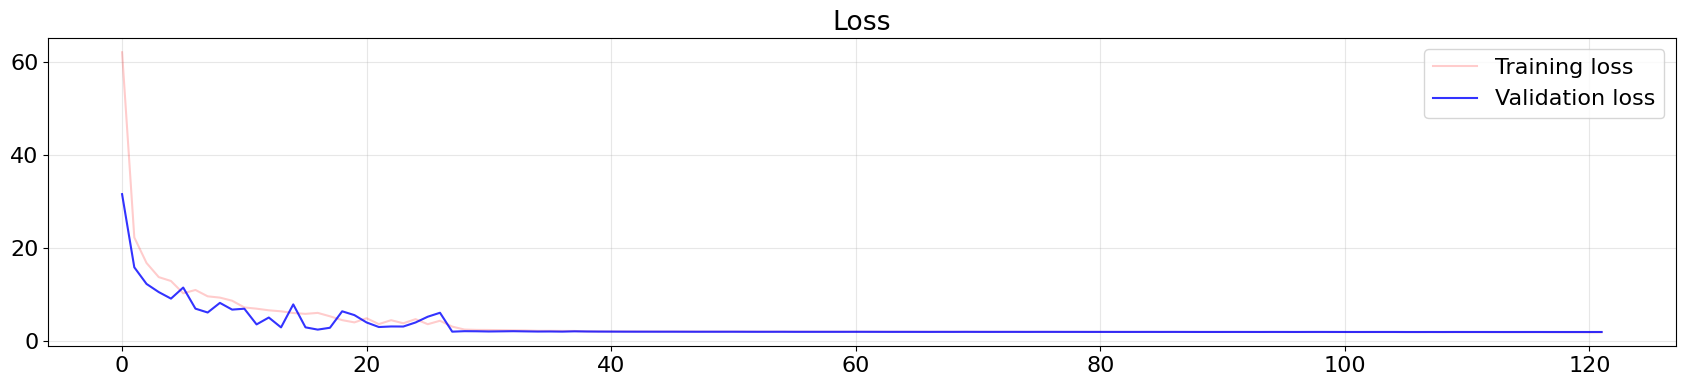

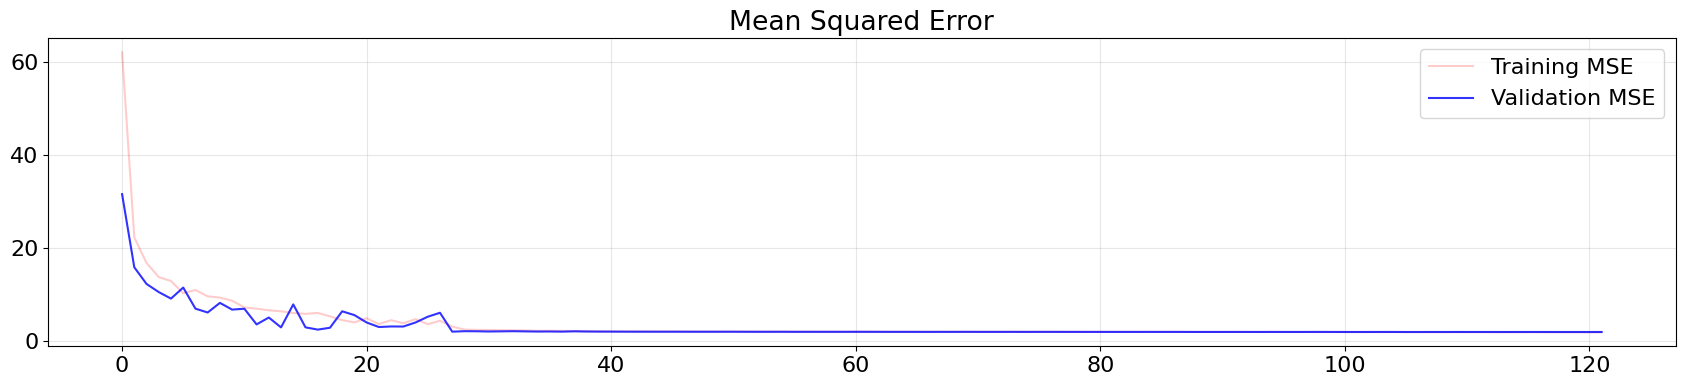

In [25]:
def plot_loss_mse(history):
    ignore = 0

    plt.figure(figsize=(21, 4))


    plt.plot(history['loss'][ignore:], label='Training loss', alpha=.2, color='red')
    plt.plot(history['val_loss'][ignore:], label='Validation loss', alpha=.8, color='blue')
    plt.title('Loss')
    plt.legend()
    plt.grid(alpha=.3)


    plt.figure(figsize=(21, 4))


    plt.plot(history['mse'][ignore:], label='Training MSE', alpha=.2, color='red')
    plt.plot(history['val_mse'][ignore:], label='Validation MSE', alpha=.8, color='blue')
    plt.title('Mean Squared Error')
    plt.legend()
    plt.grid(alpha=.3)


    plt.show()
plot_loss_mse(history_with_callbacks)

In [ ]:
def test_model(model, X_test, y_test, features):
    y_pred = model.predict(X_test)
    mape, mae, mse, r2 = bs.compute_metrics(y_test, y_pred)
    X_test_df, y_test_df = dp.from_np_to_df(X_test_unscal, y_test, features)
    bs.evaluate_bs_options_pricing(y_test_df, X_test_df)

    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=.1)
    plt.plot([0, 350], [0, 350], color='red', linestyle='--')
    plt.xlabel('Prix')
    plt.ylabel('Prix prédit')
    plt.title('Prix vs Prix prédit')
    plt.show()
test_model(model_with_callbacks, X_test, y_test, params['features'])

In [ ]:
params = {
    'test_size' : 0.1,
    'test_value' : 200, # if we choose no to train_test_split
    'n_rows' : [100, 1000, 10000, 50000, 100000],
    'name_run' : 'cb_multiple_row',
    'number_time_repeat' : 1,
    'epochs': 1000,
    'batch_size': 32,
    'features': ['strike','vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'stock_price','time_to_maturity', 'interest_rate'],
    "callbacks": {
        "EarlyStopping": {
            "monitor": "val_mse",
            "patience": 20,
            'min_delta': 0.01,
            "restore_best_weights": True,
        },
        "ReduceLROnPlateau": {
            "monitor": "val_mse",
            "factor": 0.1,
            "patience": 5,
            "min_lr": 1e-5,
        },
    }
}

In [ ]:
callbacks = [
    getattr(tfk.callbacks, name)(**params) for name, params in params['callbacks'].items()
]


In this part we automatize the training, testing and comparing with the Black-Scholes model

In [11]:
def train_test_model(params):
    dicts_save = {}
    for test_value in params['n_rows']:
        dict_save = {}
        tab_metrics = np.zeros((params['number_time_repeat'], 4))
        tab_metrics_bs = np.zeros((params['number_time_repeat'], 4))
        for i in range(params['number_time_repeat']):
            
            X_train_val, X_test, y_train_val, y_test, scaler = dp.create_train_test_set_by_act_symbol(df_options_c, params['test_size'], test_value, params['features'])
            X_test_unscal = scaler.inverse_transform(X_test)# for bs model we dont need to scale
            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=len(X_test))
            model_with_callbacks = build_model(X_train.shape[1:]) # nombre de features
            history_with_callbacks = model_with_callbacks.fit(
                X_train, 
                y_train, 
                validation_data=(X_val, y_val), 
                epochs=params['epochs'], 
                batch_size=params['batch_size'],
                callbacks=callbacks
            ).history
            y_pred = model_with_callbacks.predict(X_test)
            mape, mae, mse, r2 = bs.compute_metrics(y_test, y_pred, params, test_value)
            tab_metrics[i] = [mape, mae, mse, r2]

            # for bs evaluation 
            X_test_df, y_test_df = dp.from_np_to_df(X_test_unscal, y_test, params['features'])
            df_price_bs, mape_bs, mae_bs, mse_bs, r2_bs = bs.evaluate_bs_options_pricing(y_test_df, X_test_df)
            tab_metrics_bs[i] = [mape_bs, mae_bs, mse_bs, r2_bs]

        mean_metrics = np.mean(tab_metrics, axis=0)
        std_metrics = np.std(tab_metrics, axis=0)
        mean_metrics_bs = np.mean(tab_metrics_bs, axis=0)
        std_metrics_bs = np.std(tab_metrics_bs, axis=0)
        dict_save= {
            'name_run': params['name_run'],
            'mean_metrics': mean_metrics,
            'std_metrics': std_metrics,
            'metrics': tab_metrics,
            'mean_metrics_bs': mean_metrics_bs,
            'std_metrics_bs': std_metrics_bs,
            'metrics_bs': tab_metrics_bs,
            'params': params, 
            'history': history_with_callbacks
            }
        dicts_save[test_value] = dict_save
    return dicts_save

In [ ]:
dict_save = train_test_model(params)  

In [ ]:
dict_save   